In [1]:
import warnings
import logging
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import mlflow
import mlflow.sklearn
from pathlib import Path
import os


In [2]:
#process log tracking
logging.basicConfig(level=logging.DEBUG,
                    filename='./logfile.log',
                    filemode='w', # 'w' 表示寫模式, 'a' 表示追加模式, 'w' 表示如果文件已存在，先将其清空。如果你想在不清空现有日志的情况下向文件追加日志，可以使用 'a' 模式。
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

logger = logging.getLogger(__name__)


In [3]:
#evaluation function
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


## RAW data preparation and split data for training

In [4]:
warnings.filterwarnings("ignore")
np.random.seed(40)

# Read the wine-quality csv file from local
logger.debug("raw data ingestion")
data = pd.read_csv("data/red-wine-quality.csv")
data.to_csv("data/red-wine-quality.csv", index=False)

# Split the data into training and test sets. (0.75, 0.25) split.
logger.debug("data prep for training and testing")
train, test = train_test_split(data)
train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]



## Model training and prediction


### tracking uri


In [5]:
# set tracking folder
mlflow.set_tracking_uri(uri="")

# 全路徑寫法 file:xxxx
# mlflow.set_tracking_uri(uri=r"file:C:\Users\xdxd2\Sunny_VS_worksapce\Sunny_python\ML\mytracks")

print("The set tracking uri is ", mlflow.get_tracking_uri())



The set tracking uri is  


### experiment id


In [6]:

exp = mlflow.set_experiment( experiment_name= "lr_elasticNet_tags")


print(f"Name: {exp.name}")
print(f"Experiment_id: {exp.experiment_id}")
print(f"Artifact Location: {exp.artifact_location}")
print(f"Tags: {exp.tags}")
print(f"Lifecycle_stage: {exp.lifecycle_stage}")
print(f"Creation timestamp: {exp.creation_time}")



Name: lr_elasticNet_tags
Experiment_id: 642287713691902906
Artifact Location: file:///C:/Users/xdxd2/Sunny_VS_worksapce/Sunny_python/ML/MLOps_fundamentals/MLflow/basic/mlruns/642287713691902906
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1706511078344


## tag function


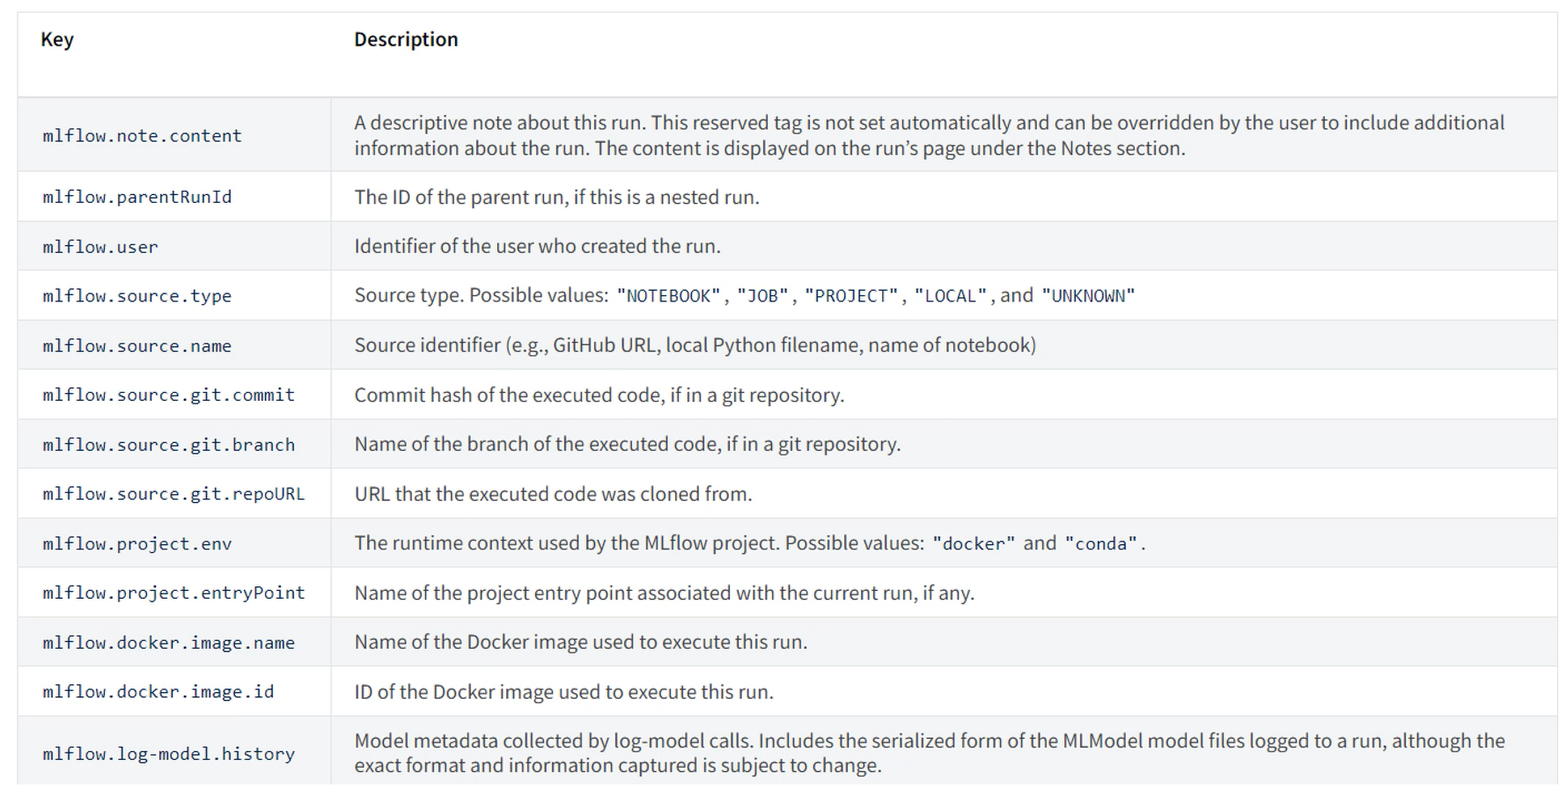

In [7]:
mlflow.start_run(experiment_id=exp.experiment_id, run_name="run_1")

# hyper parameter tuning
alpha = 0.3
l1_ratio = 0.3

# add exp tags
mlflow.set_tag("release.version", "0.1")

# add group tags
tags = {
    "engineering": "ML platform",
    "release.candidate": "RC1",
    "release.version":"2.0"
}
mlflow.set_tags(tags)

lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=62)
lr.fit(train_x, train_y)

predicted_qualities = lr.predict(test_x)

(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("Elasticnet model (alpha={:f}, l1_ratio={:f}):".format(alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)


#log parameters
params = {
    "alpha" : alpha,
    "l1_ratio": l1_ratio
}
mlflow.log_params(params)

#log metrics
metrics = {
    "rmse":rmse,
    "r2":r2,
    "mae":mae
}
mlflow.log_metrics(metrics)

#log model
mlflow.sklearn.log_model(lr, "mymodel_f86a8_end_run")
mlflow.log_artifacts("data/")


artifact_uri = mlflow.get_artifact_uri()
print(f"artifact uri: {artifact_uri}")


run = mlflow.active_run()
print(f"active run id is {run.info.run_id}")
print(f"active run name is {run.info.run_name}")

mlflow.end_run()



Elasticnet model (alpha=0.300000, l1_ratio=0.300000):
  RMSE: 0.7442929001520973
  MAE: 0.5763000946156918
  R2: 0.21508707276848893
artifact uri: file:///C:/Users/xdxd2/Sunny_VS_worksapce/Sunny_python/ML/MLOps_fundamentals/MLflow/basic/mlruns/642287713691902906/c14ee296a797487fa4e32e46e079d971/artifacts
active run id is c14ee296a797487fa4e32e46e079d971
active run name is run_1


In [9]:
exp.experiment_id

'642287713691902906'